In [129]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, label_binarize)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.metrics import classification_report
from warnings import filterwarnings

filterwarnings('ignore')

In [109]:
def resize_with_padding(image, target_size):
    original_width, original_height = image.size

    aspect_ratio = original_width / original_height
    target_width, target_height = target_size

    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_image = image.resize((new_width, new_height))

    new_image = Image.new("RGB", target_size, (255, 255, 255))

    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

In [110]:
def load_data_into_df():
    image_folder = '/content/drive/MyDrive/ML_PROJECT_DATA/CLF Data/'
    target_size = (100, 100)

    df = pd.DataFrame()

    for i in range(5):
        images_data = []

        for image_file in os.listdir(os.path.join(image_folder, str(i))):
            if image_file.endswith('.png'):
                img = Image.open(os.path.join(image_folder, str(i), image_file))
                img_resized = resize_with_padding(img, target_size)
                img_array = np.array(img_resized)
                flattened_img = img_array.flatten()
                images_data.append(flattened_img)

        class_df = pd.DataFrame(images_data)
        class_df['class'] = i

        df = pd.concat([df, class_df], axis=0, ignore_index=True)

    return df

In [144]:
def prepare_data_for_training(df):
    X = df.drop('class', axis=1).values
    y = df['class'].values

    X = X.astype('float32') / 255.0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler


In [112]:
def Logistic_Classifier(X_train, y_train):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

    model.fit(X_train, y_train)

    return model


def KNN_Classifier(X_train, y_train):
    model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')

    model.fit(X_train, y_train)

    return model

In [113]:
def model_eval(model, y_true, data, data_type, model_type):
    y_pred = model.predict(data)

    CR = classification_report(y_true, y_pred)
    CM = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({model_type} On {data_type}ing Data)')
    plt.show()

    print(f"<{model_type} Model|{data_type} Data Evaluation>\n{CR}")

In [126]:
def auc_roc_vis(model, X_test, y_test, model_type):
    classes = model.classes_
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_pred_proba = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {cls} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_type}')
    plt.legend()
    plt.show()


In [115]:
df = load_data_into_df()

In [25]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,29991,29992,29993,29994,29995,29996,29997,29998,29999,class
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


In [117]:
df['class'].value_counts() ## this shows how many images are there for every class

,count
class,
0,318
2,244
4,202
1,156
3,108


In [145]:
X_train, X_test, y_train, y_test, scaler = prepare_data_for_training(df)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((822, 30000), (206, 30000), (822,), (206,))

In [146]:
LC_model = Logistic_Classifier(X_train, y_train)
KNN_model = KNN_Classifier(X_train, y_train)

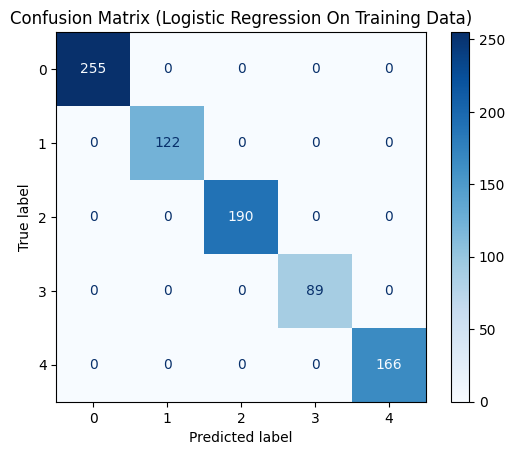

<Logistic Regression Model|Train Data Evaluation>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00       166

    accuracy                           1.00       822
   macro avg       1.00      1.00      1.00       822
weighted avg       1.00      1.00      1.00       822



In [147]:
model_eval(LC_model, y_train, X_train, "Train", "Logistic Regression")

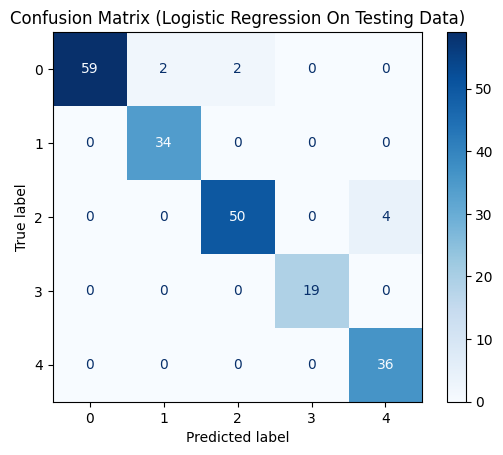

<Logistic Regression Model|Test Data Evaluation>
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.94      1.00      0.97        34
           2       0.96      0.93      0.94        54
           3       1.00      1.00      1.00        19
           4       0.90      1.00      0.95        36

    accuracy                           0.96       206
   macro avg       0.96      0.97      0.97       206
weighted avg       0.96      0.96      0.96       206



In [148]:
model_eval(LC_model, y_test, X_test, "Test", "Logistic Regression")

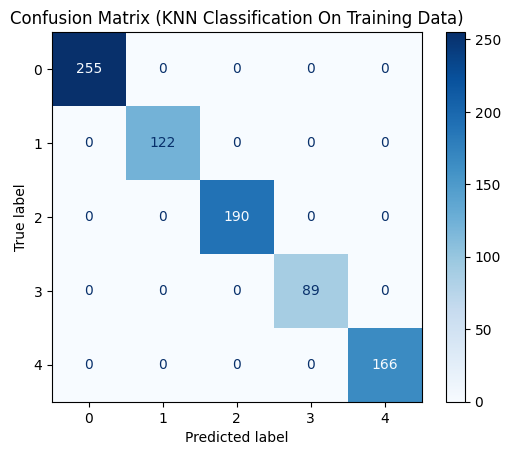

<KNN Classification Model|Train Data Evaluation>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00       166

    accuracy                           1.00       822
   macro avg       1.00      1.00      1.00       822
weighted avg       1.00      1.00      1.00       822



In [149]:
model_eval(KNN_model, y_train, X_train, "Train", "KNN Classification")

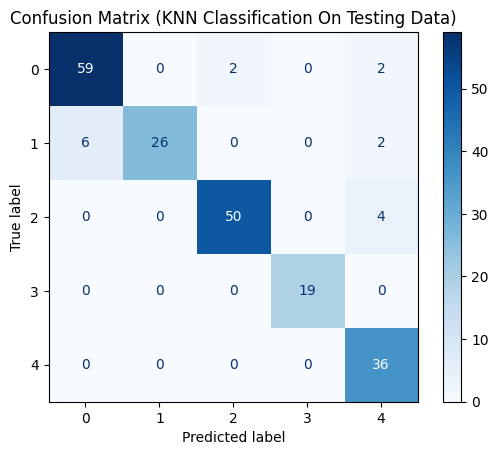

<KNN Classification Model|Test Data Evaluation>
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        63
           1       1.00      0.76      0.87        34
           2       0.96      0.93      0.94        54
           3       1.00      1.00      1.00        19
           4       0.82      1.00      0.90        36

    accuracy                           0.92       206
   macro avg       0.94      0.93      0.93       206
weighted avg       0.93      0.92      0.92       206



In [150]:
model_eval(KNN_model, y_test, X_test, "Test", "KNN Classification")

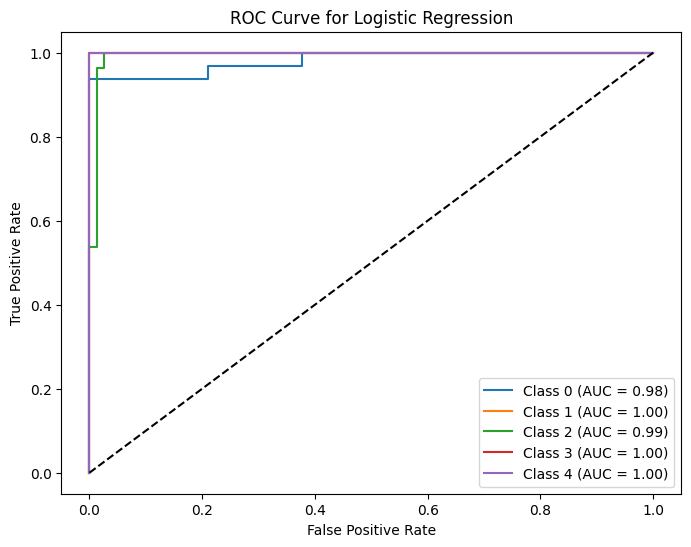

In [151]:
auc_roc_vis(LC_model, X_test, y_test, "Logistic Regression")

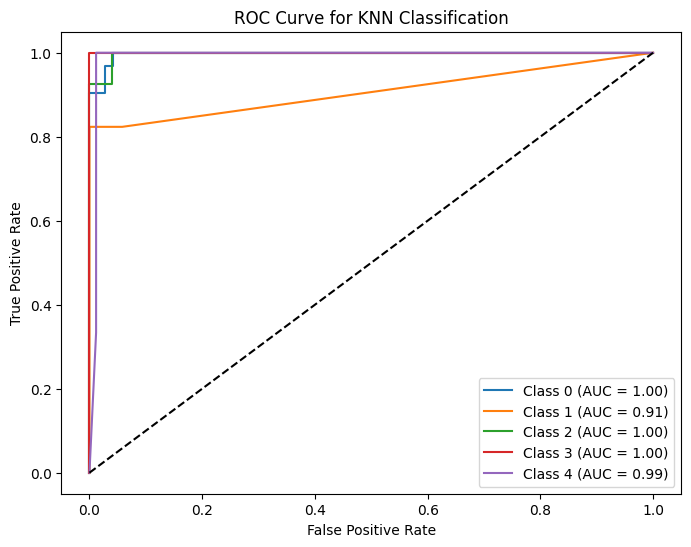

In [152]:
auc_roc_vis(KNN_model, X_test, y_test, "KNN Classification")

In [195]:
## testing the model

def get_random_ready_for_testing_img(scaler):
  image_folder = '/content/drive/MyDrive/ML_PROJECT_DATA/CLF Data/'

  target_size = (100, 100)
  label_folders = ['0', '1', '2', '3', '4']

  random_folder = random.choice(label_folders)
  random_img = random.choice(os.listdir(os.path.join(image_folder, random_folder)))

  img = Image.open(os.path.join(image_folder, random_folder, random_img))
  img_resized = resize_with_padding(img, target_size)
  img_array = np.array(img_resized)
  flattened_img = img_array.flatten().reshape(1, -1)

  flattened_img = flattened_img.astype('float32') / 255.0
  flattened_img = scaler.transform(flattened_img)

  return img, flattened_img

In [204]:
def test_the_model(model):
  img, img_for_test = get_random_ready_for_testing_img(scaler)

  classes = {0: "Speed limit Sign (40km/h)",
              1: "Speed limit Sign (50km/h)",
              2: "Speed limit Sign (60km/h)",
              3: "Speed limit Sign (70km/h)",
              4: "Speed limit Sign (80km/h)"}

  img_pred = model.predict(img_for_test)
  print(classes[int(img_pred[0])])

  return img

Speed limit Sign (60km/h)


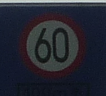

In [205]:
img = test_the_model(LC_model)
img

Speed limit Sign (70km/h)


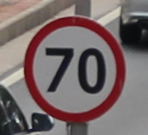

In [206]:
img = test_the_model(KNN_model)
img